# Demonstração prática do filtro de Kalman

O seguinte *notebook* explica o *setup* realizado para o uso prático do filtro de Kalman sobre a trajetória definida por coordenadas de um GPS. As principais seções, na ordem em que aparecem, são:

1) A importação e preparo do conjunto de dados analisado;
2) A definição dos parâmetros iniciais do filtro de Kalman, dadas as características do cenário abordado;
3) O laço principal do filtro, que itera sobre todos os pontos e gera estimativas;
4) A captura

## Importação e preparo do conjunto de dados

Primeiramente, são extraídas as coordenadas do arquivo `groundtruth.csv`, que definem um caminho confeccionado no programa Google Earth. Esse arquivo contém os valores de latitude e longitude para cada um dos pontos no trajeto criado.

Os dados do arquivo `groundtruth.csv` são divididos por `tabs` (`\t`), com suas colunas e dados dispostos da seguinte maneira:

| Longitude            | Latitude             |
|----------------------|----------------------|
| -43.22703800879117   | -19.62976578509858   |
| -43.22706918884194   | -19.62980394050902   |
| ...                  | ...                  |

E sua extração é feita utilizando o método `extract_lats_lons` do pacote `utils`.

In [1]:
import utils

lat_vals_gt, lon_vals_gt = utils.extract_lats_lons("groundtruth.csv")

Em seguida, o método `coords_to_relative_cartesian` do pacote `utils` realiza a conversão do valores de latitude e longitude para coordenadas do sistema cartesiano em metros, utilizando a primeira coordenada como ponto inicial `(0, 0)`, e os pontos seguintes relativos ao primeiro.

In [2]:
x_vals_gt, y_vals_gt = utils.coords_to_relative_cartesian(lat_vals_gt, lon_vals_gt)

Por conta da confecção manual do trajeto no programa Google Earth, os pontos possuem espaçamentos irregulares, cuja distância não apresenta relação com uma taxa de amostragem ou qualquer característica plausível para um cenário real. Para que o filtro de Kalman não fique sujeito a essa irregularidade, tentando estimar

Para resolver esse problema, o método `uniformize_curve` do pacote `utils` redistribui os pontos de amostragem dado o espaçamento providenciado, mantendo o formato original do trajeto.

O espaçamento para a uniformização da curva de 20 metros foi utilizado para auxiliar na visualização da curva pré e pós tratamento.

In [3]:
spacing = 20 # metros

x_vals_gt_uni, y_vals_gt_uni = utils.uniformize_curve(x_vals_gt, y_vals_gt, spacing)

Com o tratamento da uniformização da curva, é possível observar no seguinte `plot` a diferença entre os pontos originais e os novos pontos. Esse tratamento serve para que o filtro de Kalman não fique sujeito às irregularidades

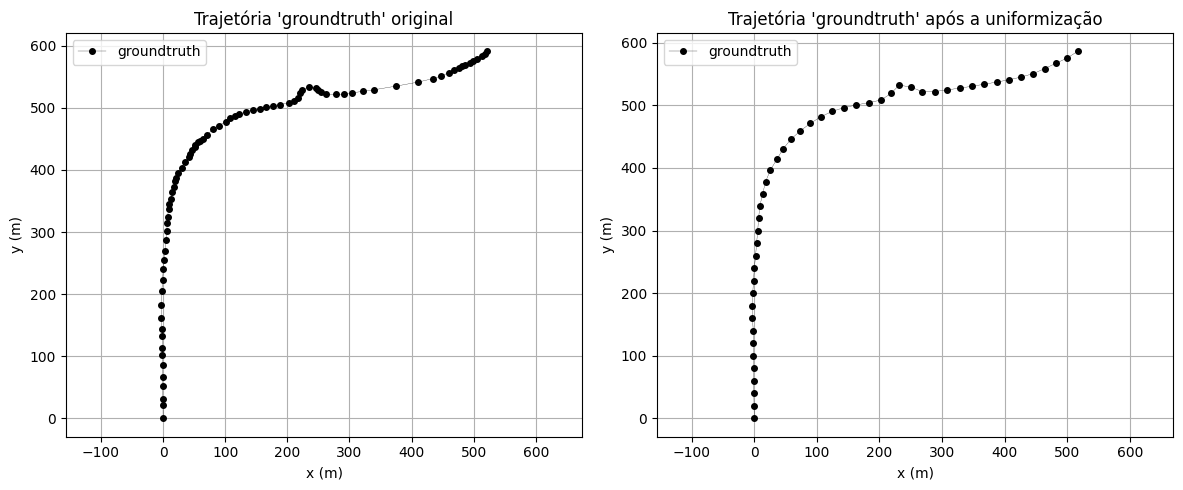

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Groundtruth original
axs[0].plot(x_vals_gt, y_vals_gt, marker='o', markersize=4, linewidth=0.2, color='k', label='groundtruth')
axs[0].set_title("Trajetória 'groundtruth' original")
axs[0].set_xlabel("x (m)")
axs[0].set_ylabel("y (m)")
axs[0].axis("equal")
axs[0].grid(True)
axs[0].legend()

# Groundtruth pós uniformização
axs[1].plot(x_vals_gt_uni, y_vals_gt_uni, marker='o', markersize=4, linewidth=0.2, color='k', label='groundtruth')
axs[1].set_title("Trajetória 'groundtruth' após a uniformização")
axs[1].set_xlabel("x (m)")
axs[1].set_ylabel("y (m)")
axs[1].axis("equal")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

Em seguida, é adicionado ruído gaussiano à trajetória '*groundtruth*', simulando a captura ruidosa de um sensor com um desvio padrão dado por `noise_lvl`.

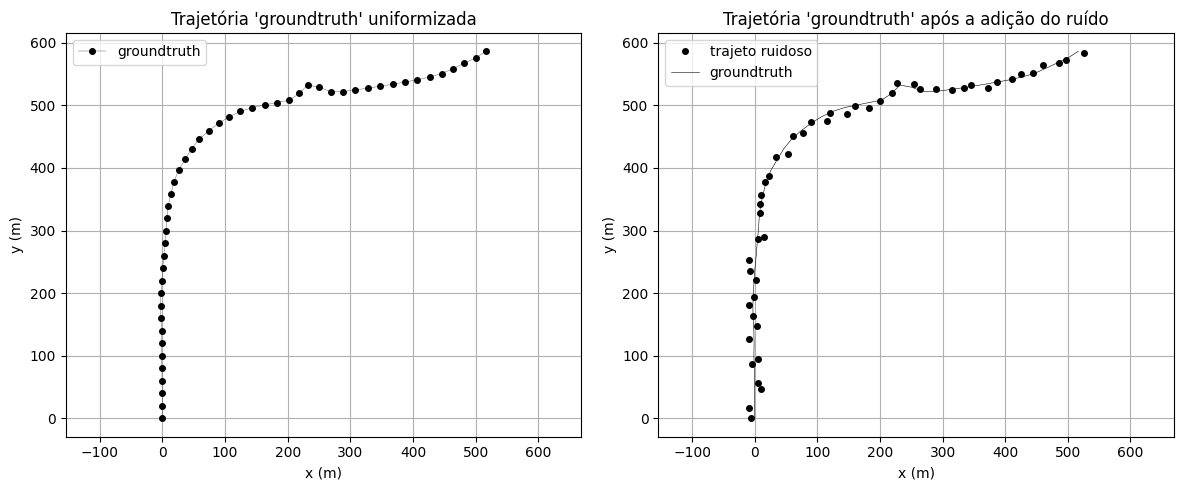

In [5]:
import numpy as np

noise_lvl = 5

n = len(x_vals_gt_uni) # Número de amostras

x_noisy = x_vals_gt_uni + np.random.randn(n) * noise_lvl
y_noisy = y_vals_gt_uni + np.random.randn(n) * noise_lvl

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Groundtruth original
axs[0].plot(x_vals_gt_uni, y_vals_gt_uni, marker='o', markersize=4, linewidth=0.2, color='k', label='groundtruth')
axs[0].set_title("Trajetória 'groundtruth' uniformizada")
axs[0].set_xlabel("x (m)")
axs[0].set_ylabel("y (m)")
axs[0].axis("equal")
axs[0].grid(True)
axs[0].legend()

# Groundtruth pós uniformização
axs[1].plot(x_noisy, y_noisy, marker='o', markersize=4, linewidth=0, color='k', label='trajeto ruidoso')
axs[1].plot(x_vals_gt_uni, y_vals_gt_uni, linewidth=0.4, color='r', label='groundtruth')
axs[1].set_title("Trajetória 'groundtruth' após a adição do ruído")
axs[1].set_xlabel("x (m)")
axs[1].set_ylabel("y (m)")
axs[1].axis("equal")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

O objetivo é implementar um filtro de Kalman capaz de criar um trajeto que se aproxime da rota '*groundtruth*', ajustando parâmetros iniciais e deliberando sobre o modelo matemático ideal para o cenário criado.

## Parâmetros iniciais do filtro de Kalman